In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from collections import deque
import torch
import copy

# Import from the provided skeleton files
from grid_world import GridWorld, Agent, init_agents, actions
from stage2skeletonv3 import prepare_torch, update_target, get_qvals, get_maxQ, train_one_step, statespace_size

# Constants
GRID_SIZE = 5
NUM_AGENTS = 4
MAX_STEPS = 25
TRAINING_EPISODES = 10000
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.9995
GAMMA = 0.95
BATCH_SIZE = 128
MEMORY_SIZE = 2000
UPDATE_TARGET_EVERY = 200
MAX_TRAINING_STEPS = 1500000
MAX_COLLISIONS = 4000
MAX_TRAINING_TIME = 600  # 10 minutes

class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.memory, min(batch_size, len(self.memory)))
    
    def __len__(self):
        return len(self.memory)

# Convert string action to index
def action_to_index(action):
    return actions.index(action)

# Convert index to string action
def index_to_action(index):
    return actions[index]

# Generate off-the-job training schedule
def generate_training_schedule(num_episodes, grid_size=GRID_SIZE, num_agents=NUM_AGENTS):
    """Generate custom starting configurations for off-the-job training"""
    schedules = []
    
    for _ in range(num_episodes):
        # Random A and B positions
        location_a = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        
        while True:
            location_b = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
            if location_b != location_a:
                break
        
        # Create agents with controlled distribution
        agents = []
        num_at_a = random.randint(1, num_agents-1)  # At least 1 at each location
        num_at_b = num_agents - num_at_a
        
        # Add agents at location A
        for i in range(num_at_a):
            agents.append(Agent(i+1, location_a, True, location_a))
        
        # Add agents at location B
        for i in range(num_at_a, num_agents):
            agents.append(Agent(i+1, location_b, False, location_a))
        
        # Shuffle agent order
        random.shuffle(agents)
        
        schedules.append({
            'location_a': location_a,
            'location_b': location_b,
            'agents': agents
        })
    
    return schedules

# Compute TD target
def TD_target(reward, gamma, done, qMax): 
    target = reward + gamma*(1-done)*qMax
    return target

# Select action using epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.choice(actions)
    else:
        qvals = get_qvals(state)
        return index_to_action(np.argmax(qvals))

# Train agents
def train():
    # Initialize torch models
    global model
    model = prepare_torch()
    
    # Create replay buffer
    memory = ReplayBuffer(MEMORY_SIZE)
    
    # Generate training schedule
    training_schedule = generate_training_schedule(TRAINING_EPISODES)
    
    # Training stats
    episode_rewards = []
    collision_counts = []
    step_counts = []
    total_collisions = 0
    total_steps = 0
    epsilon = EPSILON_START
    
    # Start timing
    start_time = time.time()
    
    # Training loop
    for episode in range(TRAINING_EPISODES):
        # Use the training schedule for this episode
        schedule = training_schedule[episode]
        
        # Create GridWorld with the scheduled configuration
        gw = GridWorld(GRID_SIZE, GRID_SIZE, schedule['location_a'], schedule['location_b'], schedule['agents'])
        agents_dict = gw.get_agents_dict()
        
        episode_reward = 0
        episode_collisions = 0
        episode_steps = 0
        
        # Initialize agent order for updates (random order as per assignment)
        agent_ids = list(agents_dict.keys())
        random.shuffle(agent_ids)
        
        # Run episode
        for step in range(MAX_STEPS):
            # For each agent in random order
            for agent_id in agent_ids:
                agent = agents_dict[agent_id]
                
                # # If agent already completed delivery, skip
                # if agent.done:
                #     continue
                
                # Get state
                state = gw.get_np_state_for_agent(agent).reshape(1, statespace_size)
                
                # Select action using epsilon-greedy
                action = select_action(state, epsilon)
                
                # Take action and observe reward
                reward = gw.attempt_action_for_agent(agent, action)
                
                # If collision occurred, increment collision counter
                if reward <= -20:  # Collision penalty threshold
                    episode_collisions += 1
                    total_collisions += 1
                
                # Get next state
                next_state = gw.get_np_state_for_agent(agent).reshape(1, statespace_size)
                
                # Store experience in replay buffer
                action_idx = action_to_index(action)

                done = False
                if (agent.num_collisions > 0) or (agent.num_steps > 25):
                    done = True

                memory.add(state, action_idx, reward, next_state, done)
                
                # Learn from experiences (if enough samples)
                if len(memory) >= BATCH_SIZE:
                    # Sample mini-batch
                    batch = memory.sample(BATCH_SIZE)
                    
                    # Prepare batches for training
                    states = []
                    actions = []
                    td_targets = []
                    
                    for b_state, b_action, b_reward, b_next_state, b_done in batch:
                        # Calculate TD Target
                        q_max = get_maxQ(b_next_state)
                        td_target_val = TD_target(b_reward, GAMMA, b_done, q_max)
                        
                        states.append(b_state)
                        actions.append(b_action)
                        td_targets.append(td_target_val)
                    
                    # Train the model
                    loss = train_one_step(states, actions, td_targets, GAMMA)
                
                # Update target network
                if total_steps % UPDATE_TARGET_EVERY == 0:
                    update_target()
                
                # Update stats
                episode_reward += reward
                total_steps += 1
                episode_steps += 1
                
                # Check if we've reached the maximum training steps
                if total_steps >= MAX_TRAINING_STEPS:
                    print(f"Reached maximum training steps: {total_steps}")
                    return episode_rewards, collision_counts, step_counts
                
                # Check if we've exceeded collision budget
                if total_collisions >= MAX_COLLISIONS:
                    print(f"Exceeded collision budget: {total_collisions}")
                    return episode_rewards, collision_counts, step_counts
                
                # Check time budget
                if time.time() - start_time > MAX_TRAINING_TIME:
                    print(f"Exceeded time budget: {time.time() - start_time:.2f}s")
                    return episode_rewards, collision_counts, step_counts
        
        # Update epsilon
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
        
        # Update training stats
        episode_rewards.append(episode_reward)
        collision_counts.append(episode_collisions)
        step_counts.append(episode_steps)
        
        # Print progress
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_collisions = np.mean(collision_counts[-100:])
            avg_steps = np.mean(step_counts[-100:])
            elapsed_time = time.time() - start_time
            
            print(f"Episode {episode+1}/{TRAINING_EPISODES} | "
                  f"Avg Reward: {avg_reward:.2f} | "
                  f"Avg Collisions: {avg_collisions:.2f} | "
                  f"Avg Steps: {avg_steps:.2f} | "
                  f"Total Collisions: {total_collisions} | "
                  f"Total Steps: {total_steps} | "
                  f"Epsilon: {epsilon:.4f} | "
                  f"Elapsed Time: {elapsed_time:.2f}s")
    
    # Final stats
    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    print(f"Total steps: {total_steps}")
    print(f"Total collisions: {total_collisions}")
    
    return episode_rewards, collision_counts, step_counts

# Evaluate agents
def evaluate(num_episodes=100):
    success_count = 0
    total_steps = 0
    total_collisions = 0
    
    for episode in range(num_episodes):
        # Create a random test environment
        location_a = (random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1))
        
        while True:
            location_b = (random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1))
            if location_b != location_a:
                break
        
        # Always start at least one agent at B going to A to test delivery
        agents = []
        agents.append(Agent(1, location_b, False, location_a))  # First agent always at B
        
        # Add other agents randomly
        for i in range(1, NUM_AGENTS):
            start_loc = random.choice([location_a, location_b])
            reached_a = (start_loc == location_a)
            agents.append(Agent(i+1, start_loc, reached_a, location_a))
        
        # Create grid world
        gw = GridWorld(GRID_SIZE, GRID_SIZE, location_a, location_b, agents)
        agents_dict = gw.get_agents_dict()
        
        # Count initial agents at B going to A
        initial_deliveries_needed = sum(1 for agent in agents_dict.values() 
                                  if agent.pos == location_b and not agent.reached_a)
        
        episode_steps = 0
        episode_collisions = 0
        deliveries_completed = 0
        
        # Run episode
        for step in range(MAX_STEPS):
            # For each agent in random order
            agent_ids = list(agents_dict.keys())
            random.shuffle(agent_ids)
            
            for agent_id in agent_ids:
                agent = agents_dict[agent_id]
                
                # If agent already completed delivery, skip
                if agent.done:
                    continue
                
                # Get state
                state = gw.get_np_state_for_agent(agent)
                
                # Select best action (no exploration)
                qvals = get_qvals(state)
                action = index_to_action(np.argmax(qvals))
                
                # Take action
                reward = gw.attempt_action_for_agent(agent, action)
                
                # Track collisions
                if reward <= -20:  # Collision penalty threshold
                    episode_collisions += 1
                
                # Check if delivery completed
                if agent.done:
                    deliveries_completed += 1
            
            episode_steps += 1
            
            # Check if all initial agents have completed a delivery
            if deliveries_completed >= initial_deliveries_needed:
                break
        
        # Episode is successful if enough deliveries completed without collisions
        if episode_collisions == 0 and deliveries_completed > 0 and episode_steps <= MAX_STEPS:
            success_count += 1
        
        total_steps += episode_steps
        total_collisions += episode_collisions
    
    success_rate = success_count / num_episodes
    avg_steps = total_steps / num_episodes
    avg_collisions = total_collisions / num_episodes
    
    print(f"Evaluation Results:")
    print(f"Success Rate: {success_rate:.2f}")
    print(f"Average Steps: {avg_steps:.2f}")
    print(f"Average Collisions: {avg_collisions:.2f}")
    
    return success_rate, avg_steps, avg_collisions


# Visualize training progress
def plot_training_progress(episode_rewards, collision_counts, step_counts):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    # Plot rewards
    axs[0].plot(episode_rewards)
    axs[0].set_title('Episode Rewards')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    
    # Plot collisions
    axs[1].plot(collision_counts)
    axs[1].set_title('Episode Collisions')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Collisions')
    
    # Plot steps
    axs[2].plot(step_counts)
    axs[2].set_title('Episode Steps')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Steps')
    
    plt.tight_layout()
    plt.show()

In [2]:
# Train agents
episode_rewards, collision_counts, step_counts = train()



Episode 50/10000 | Avg Reward: -251.42 | Avg Collisions: 0.00 | Avg Steps: 100.00 | Total Collisions: 0 | Total Steps: 5000 | Epsilon: 0.9753 | Elapsed Time: 68.60s
Episode 100/10000 | Avg Reward: -269.46 | Avg Collisions: 0.00 | Avg Steps: 100.00 | Total Collisions: 0 | Total Steps: 10000 | Epsilon: 0.9512 | Elapsed Time: 138.90s


KeyboardInterrupt: 

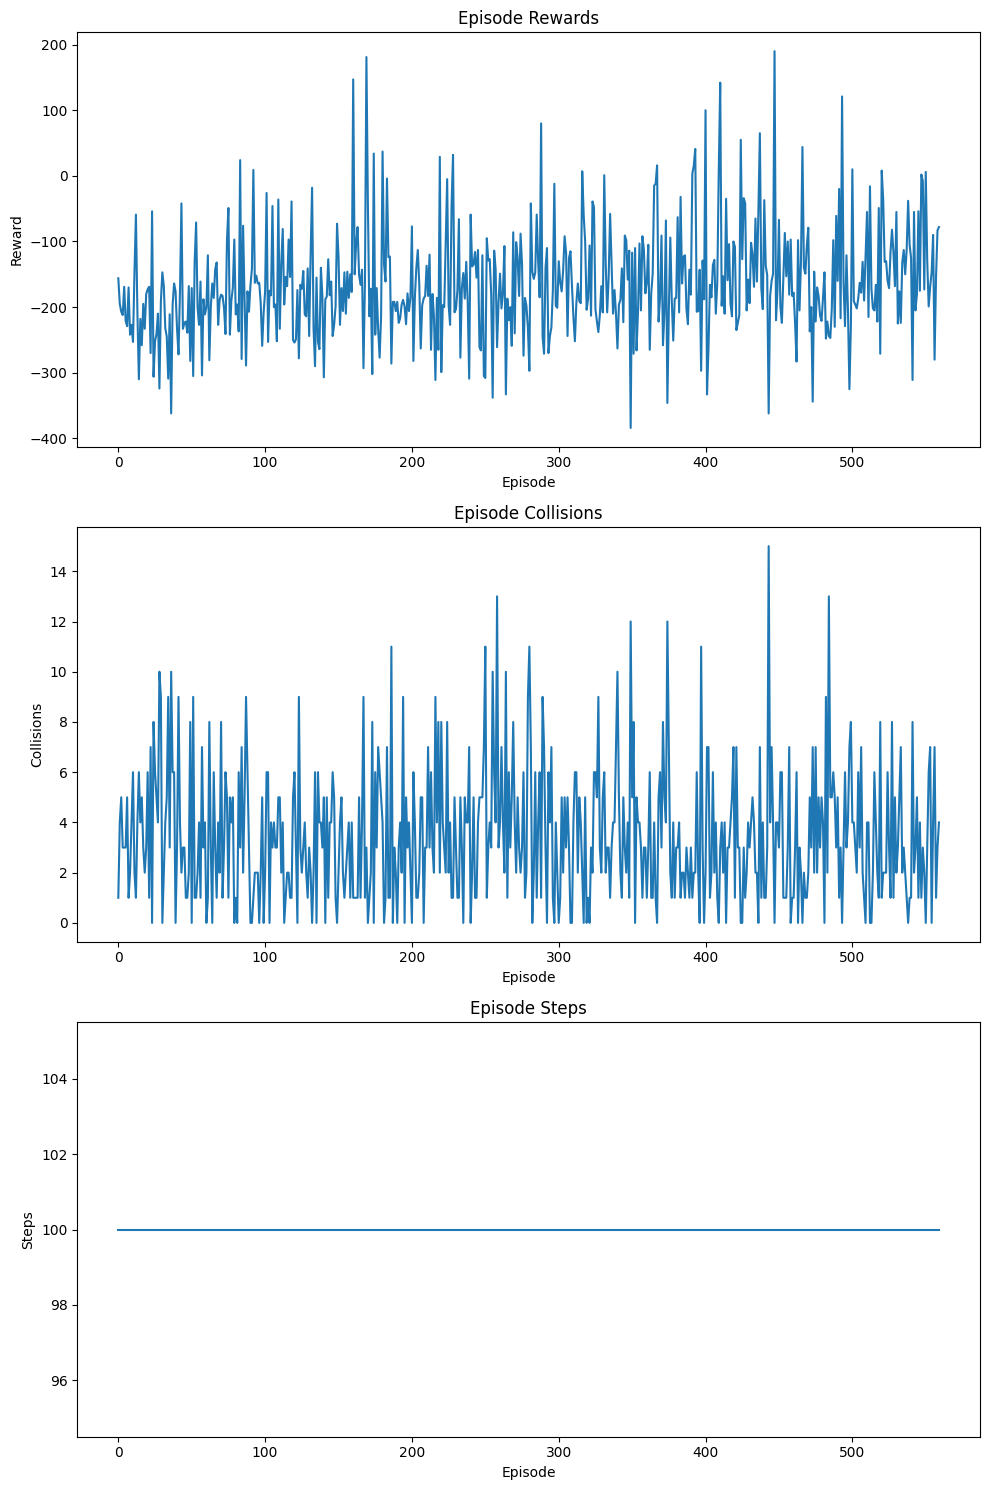

In [3]:
# Plot training progress
plot_training_progress(episode_rewards, collision_counts, step_counts)

In [8]:
action_set = {0: 'n', 1: 'e', 2: 's', 3: 'w'}

def test_once(model, loc_a, loc_b, display=True):

    n = 5
    m = 5

    max_steps = 25

    # 1st agent always begins at B
    agents = init_agents(4, loc_a, loc_b)

    gw = GridWorld(n, m, loc_a, loc_b, agents)

    focal_agent_idx = 0

    states_ = [gw.get_np_state_for_agent(agent).reshape(1, statespace_size) for agent in agents]
    states = [torch.from_numpy(state_).float() for state_ in states_]

    if display:
        print("initial state:")
        gw.display()
        print("focal agent is", agents[focal_agent_idx].id)

    for s in range( (len(agents)*25) + 1 ):

        for idx in range(len(agents)):

                qval = model(states[idx])
                qval_ = qval.data.numpy()
                action_ = np.argmax(qval_)
                action = action_set[action_]

                rew = gw.attempt_action_for_agent(agents[idx], action)

                if display:
                    print(f"agent {agents[idx].id} took action {action} and got rewarded {rew}")
                    print(gw.display())
                
                state_ = gw.get_np_state_for_agent(agents[idx]).reshape(1, statespace_size)
                state = torch.from_numpy(state_).float()
                states[idx] = state
        
        # whichever if condition is met first will return
        if (agents[focal_agent_idx].num_steps > max_steps):
            if display:
                print("test unsuccessful - too many steps")
            return False
        
        if (agents[focal_agent_idx].num_collisions > 0):
            if display:
                print("test unsuccessful - focal agent collided with an agent of the opposite type")
            return False

        if (agents[focal_agent_idx].reached_a):
            if display:
                print(f"test success - focal agent {agents[focal_agent_idx].id} reached A without collisions in under 25 steps")
            return True

    # ideally this line must never execute - if conditions should handle everything
    return False

In [10]:
def test_stats(model):
  max_games = 1000
  wins = 0
  for i in range(max_games):
      
      loc_a = ( random.randint(0,4), random.randint(0,4) )
      loc_b = ( random.randint(0,4), random.randint(0,4) )

      win = test_once(model, loc_a, loc_b, display=False)
      if win:
          wins += 1

  win_perc = float(wins) / float(max_games)
  print("Games played: {0}, # of wins: {1}".format(max_games,wins))
  print("Win percentage: {}".format(win_perc))


test_stats(model)

Games played: 1000, # of wins: 398
Win percentage: 0.398
